In [185]:
import pandas as pd
import numpy as np
import scipy as sp
import pulp
from scipy.optimize import linprog
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable, LpMinimize
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
# Assuming FoodDatabase.csv is in the same directory as your Jupyter Notebook
file_path = 'FoodDatabase.csv'
#All numbers (macros and micros) in the table are a serving of 100g
#When adding new foods to the csv, must fill in: protein / kg column, protein quality column (1 or 0), and product name column.
#For the spices atm using prices from greece bulk online spice store, euro / kg converted to $ / kg 

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Filter rows with nonzero 'Price / kg'
df_filtered = df[df['Price / kg'] != 0]

# Replace NaNs with 0s
df_filtered = df_filtered.fillna(0)

# Add 'Cost ($)' column with initial value of zero at the start
df_filtered.insert(0, 'Cost ($)', 0)

# Add Quantities' (g)' column with initial value of zero as the second column
df_filtered.insert(1, 'Quantities (g)', 0)

# Display the first few rows of the DataFrame to verify it was read correctly
df_filtered.info()
df_filtered.head()

#We want to minimize c_1 * x_1 + c_2 * x_2 ... c_n * x_n , where c is the cost per unit mass of a given food, and x is the mass of the given food (aka the objective function)

# The constraints are the macros and micros of a diet, and other conditions we set and must be met. 

#Excel was using Simplex LP method


<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, 751 to 14169
Columns: 107 entries, Cost ($) to is Pill
dtypes: float64(97), int64(3), object(7)
memory usage: 34.6+ KB


C:\Users\Markos\AppData\Local\Temp\ipykernel_6488\1341582367.py:8: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Cost ($),Quantities (g),ID,name,Category,Calories,Fat (g),Protein (g),Carbohydrate (g),Sugars (g),...,Theobromine (mg),200 Calorie Weight (g),Sugar (g),Price / kg,Protein Quality,Product Name,Last Updated,Source,Comments,is Pill
751,0,0,168263,Pork Fresh Loin Center Loin (Chops) Boneless S...,Meats,122.81,3.09,23.75,0.00,0.00,...,0.0,162.602,0.00,5.158811,1.0,Smithfield Fresh Pork Center Cut Loin Boneless...,01-Feb-24,https://www.walmart.com/ip/Smithfield-Fresh-Po...,0,0
1365,0,0,168877,Rice White Long-Grain Regular Raw Enriched,Grains and Pasta,349.06,0.66,7.13,79.95,0.12,...,0.0,54.795,0.06,1.228000,0.0,"Great Value Long Grain Enriched Rice, 20 lb USA",01-Feb-24,https://www.walmart.com/ip/Great-Value-Lentils...,0,0
1382,0,0,168894,Wheat Flour White All-Purpose Enriched Bleached,Grains and Pasta,344.58,0.98,10.33,76.31,0.27,...,0.0,54.945,0.00,1.080264,0.0,"Great Value All-Purpose Flour, 5LB Bag USA",24-Feb-24,https://www.walmart.com/ip/Great-Value-All-Pur...,0,0
1775,0,0,169287,Spinach Frozen Chopped Or Leaf Unprepared,Vegetables,24.89,0.57,3.63,4.21,0.65,...,0.0,689.655,0.30,3.410000,0.0,"Great Value Chopped Spinach, 12 oz (Frozen)",0,0,0,0
2224,0,0,169736,Pasta Dry Enriched,Grains and Pasta,351.63,1.51,13.04,74.67,2.67,...,0.0,53.908,0.35,1.999590,0.0,"Great Value Elbows, 48 oz PASTA USA",01-Feb-24,https://www.walmart.com/ip/Great-Value-Elbows-...,"not worth it in the US, dairy better, pricey",0


In [187]:
# Define base class for constraints
class Constraint:
    def __init__(self, model, variables, coefficients, name):
        self.model = model
        self.variables = variables
        self.coefficients = coefficients
        self.name = name

    def get_sum(self):
        return lpSum(self.variables[i] * self.coefficients[i-1] for i in range(1, len(self.variables) + 1))

class RangeConstraint(Constraint):
    def __init__(self, model, variables, coefficients, name, lower_bound, upper_bound):
        super().__init__(model, variables, coefficients, name)
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def add_constraints(self):
        sum_expr = self.get_sum()
        self.model += (sum_expr >= self.lower_bound, f"{self.name} Lower Bound Constraint")
        self.model += (sum_expr <= self.upper_bound, f"{self.name} Upper Bound Constraint")

class MinimumConstraint(Constraint):
    def __init__(self, model, variables, coefficients, name, minimum):
        super().__init__(model, variables, coefficients, name)
        self.minimum = minimum

    def add_constraint(self):
        sum_expr = self.get_sum()
        self.model += (sum_expr >= self.minimum, f"{self.name} Minimum Constraint")

class EqualityConstraint(Constraint):
    def __init__(self, model, variables, coefficients, name, value):
        super().__init__(model, variables, coefficients, name)
        self.value = value

    def add_constraint(self):
        sum_expr = self.get_sum()
        self.model += (sum_expr == self.value, f"{self.name} Equality Constraint")

class MaximumConstraint(Constraint):
    def __init__(self, model, variables, coefficients, name, maximum):
        super().__init__(model, variables, coefficients, name)
        self.maximum = maximum

    def add_constraint(self):
        sum_expr = self.get_sum()
        self.model += (sum_expr <= self.maximum, f"{self.name} Maximum Constraint")

# Define the model (for maintenance macro + micros)
maintenance_model = LpProblem(name="Maintenance_Diet_Minimum_Cost", sense=LpMinimize)

# Define the decision variables (what we are solving for; quantities of each food)
x = {i: LpVariable(name=f"x_{i}", lowBound=0, upBound=10000) for i in range(1, len(df_filtered)+1)}

# Function to extract column array from a DataFrame with optional scaling
def extract_column_array(df, column, scale_factor=1):
    values = df.iloc[:, column].values
    if np.issubdtype(values.dtype, np.number):
        return values / scale_factor
    return values

# Index dictionary for human-readable names
index = {
    "dollars_per_g": (100, 1000),
    "name_per_food": (102, 1),
    "db_name_per_food": (3, 1),
    "category_per_food": (4, 1),
    "is_pill_per_food": (106, 1), # is or is not a pill (supplement)
    "calories_per_g": (5, 100), # scale factor in these is 100 to convert 100g into g
    "protein_per_g": (7, 100),
    "net_carbs_per_g": (95, 100),
    "fiber_per_g": (10, 100),
    "fat_per_g": (6, 100),
    "protein_quality": (101, 1),
    "sugar_per_g": (99, 100),
    "satfat_per_g": (12, 100),
    "calcium_per_g": (13, 100),
    "iron_per_g": (14, 100),
    "potassium_per_g": (15, 100),
    "magnesium_per_g": (16, 100),
    "sodium_per_g": (38, 100),
    "zinc_per_g": (39, 100),
    "copper_per_g": (40, 100),
    "manganese_per_g": (41, 100),
    "selenium_per_g": (42, 100),
    "vitaminC_per_g": (19, 100),
    "niacin_per_g": (48, 100),
    "EPA_per_g": (72, 100),
    "DHA_per_g": (74, 100),
    "beta_carotene_per_g": (59, 100),
    "alpha_carotene_per_g": (60, 100),
    "lycopene_per_g": (61, 100),
    "lut_zeaxanthin_per_g": (62, 100),
    "vitaminE_per_g": (22, 100),
}

# Function to get the array for a given nutrient type
def get_nutrient_array(nutrient_type: str):
    if nutrient_type in index:
        col, scale = index[nutrient_type]
        return extract_column_array(df_filtered, col, scale)
    else:
        raise ValueError(f"Nutrient type '{nutrient_type}' is not recognized")

dollars_per_g = get_nutrient_array("dollars_per_g")
name_per_food = get_nutrient_array("name_per_food")
db_name_per_food = get_nutrient_array("db_name_per_food")
category_per_food = get_nutrient_array("category_per_food")
is_pill_per_food = get_nutrient_array("is_pill_per_food")

# Macros arrays
calories_per_g = get_nutrient_array("calories_per_g")
protein_per_g = get_nutrient_array("protein_per_g")
net_carbs_per_g = get_nutrient_array("net_carbs_per_g")
fiber_per_g = get_nutrient_array("fiber_per_g")
fat_per_g = get_nutrient_array("fat_per_g")
protein_quality = get_nutrient_array("protein_quality")
sugar_per_g = get_nutrient_array("sugar_per_g")
satfat_per_g = get_nutrient_array("satfat_per_g")

# Micros arrays
calcium_per_g = get_nutrient_array("calcium_per_g")
iron_per_g = get_nutrient_array("iron_per_g")
potassium_per_g = get_nutrient_array("potassium_per_g")
magnesium_per_g = get_nutrient_array("magnesium_per_g")
sodium_per_g = get_nutrient_array("sodium_per_g")
zinc_per_g = get_nutrient_array("zinc_per_g")
copper_per_g = get_nutrient_array("copper_per_g")
manganese_per_g = get_nutrient_array("manganese_per_g")
selenium_per_g = get_nutrient_array("selenium_per_g")
vitaminC_per_g = get_nutrient_array("vitaminC_per_g")
niacin_per_g = get_nutrient_array("niacin_per_g")
DHA_per_g = get_nutrient_array("EPA_per_g")
EPA_per_g = get_nutrient_array("DHA_per_g")
FishOils_per_g = EPA_per_g + DHA_per_g
beta_carotene_per_g = get_nutrient_array("beta_carotene_per_g")
alpha_carotene_per_g = get_nutrient_array("alpha_carotene_per_g")
lycopene_per_g = get_nutrient_array("lycopene_per_g")
lut_zeaxanthin_per_g = get_nutrient_array("lut_zeaxanthin_per_g")
vitaminE_per_g = get_nutrient_array("vitaminE_per_g")

#weird carotenoids not included
#fucoxanthin (found in seaweed?), astaxanthin (found in crab, lobster?)

# Objective Function
maintenance_model += lpSum(x[i] * dollars_per_g[i-1] for i in range(1, len(df_filtered)+1))

# Defining Constraints
# TODO: PULL THESE FROM SOMEWHERE ELSE, MAYBE READ CSV THAT HAS BODYWEIGHT AND OTHER STATS AND COMPUTE THE MAINTENANCE AND OTHER NEEDS BASED ON 
#Constants (Determinants of variables)
Weight_lbs = 194
BF_Percent = 0.17
LBM = Weight_lbs-(Weight_lbs*BF_Percent)

#For Maintenance
Caloric_Multiplier = 15.1 #Calculated based on pre-cut maintenance; use a value 16-18 typically
Extra_Caloric_Multiplier = 1 #Percentage, use for extra 'fudge' factor tbh?
#####################################################

# Macros
maintenance_calories = Weight_lbs*Caloric_Multiplier*Extra_Caloric_Multiplier  # set maintenance calories
protein_minimum = 1.5*LBM # 1.1 - 1.4 g / lbm protein for athletes, 1.4 - 1.5 g / lbm protein when dieting, (I'm just using the top of the range 1.5 g / lbm cuz im awesome)
fiber_lbound = 30  # lower bound for fiber
fiber_ubound = 60  # upper bound for fiber
fat_lbound = 0.25*maintenance_calories/9
fat_ubound = 0.35*maintenance_calories/9 #not really necessary, but why not, carbs provide more energy anyway
net_carb_minimum = (maintenance_calories-(protein_minimum*4+fat_ubound*9))/4  # set net carb minimum
protein_quality_minimum = 0.4  # this is a fraction ie 0.4 = 40%
sugar_maximum = 75
sat_fat_maximum = 0.5  # this is a fraction

# Macro constraints using classes
macro_constraints = [
    EqualityConstraint(maintenance_model, x, calories_per_g, "Maintenance Calories", maintenance_calories),
    MinimumConstraint(maintenance_model, x, protein_per_g, "Protein", protein_minimum),
    MinimumConstraint(maintenance_model, x, net_carbs_per_g, "Net Carb", net_carb_minimum),
    RangeConstraint(maintenance_model, x, fiber_per_g, "Fiber", fiber_lbound, fiber_ubound),
    RangeConstraint(maintenance_model, x, fat_per_g, "Fat", fat_lbound,fat_ubound),
    MinimumConstraint(maintenance_model, x, [protein_quality[i-1] * protein_per_g[i-1] for i in range(1, len(x)+1)], "Protein Quality", protein_quality_minimum * lpSum(x[i] * protein_per_g[i-1] for i in range(1, len(x)+1))), # Remember, divisions need to be reformulated in the inequality as multiplications to solve properly.
    MaximumConstraint(maintenance_model, x, sugar_per_g, "Sugar", sugar_maximum),
    MaximumConstraint(maintenance_model, x, [satfat_per_g[i-1] for i in range(1, len(x)+1)], "SatFat", sat_fat_maximum * lpSum(x[i] * fat_per_g[i-1] for i in range(1, len(x)+1))) # Currently Fast and loose with fat rules. Sat fats no more than 50% of total fats. May change this in the future.
]

# Add macro constraints to the model
for constraint in macro_constraints:
    constraint.add_constraint() if isinstance(constraint, (MinimumConstraint, EqualityConstraint, MaximumConstraint)) else constraint.add_constraints()

# Micros (mg unless otherwise stated)
calcium_lbound = 1500
calcium_ubound = 2000
iron_lbound = 30
iron_ubound = 40
potassium_maximum = 10000
magnesium_lbound = 600  # Maybe play around with the calcium to magnesium ratios; apparently should be within 1.70 - 2.60 , but high calcium recommendations and maximum magnesium daily intake of 420 mg makes that difficult to attain. Let's stretch it to 1.70 - 3.15 (this probably doesn't matter if you get enough of everything)
magnesium_ubound = 700
sodium_maximum = 5000  # because potassium maximum is 10k, you want potassium to sodium ratio to be 2:1 or higher; but if you sweat a lot, probably can exceed it. just make sure potassium is at least 1:1 with sodium.
zinc_lbound = 35
zinc_ubound = 40
copper_maximum = 10
manganese_lbound = 8 # Probably more than ample
manganese_ubound = 20
selenium_maximum = 350  # micrograms
vitaminC_lbound = 120 # spread between 3 meals? 
vitaminC_ubound = 180
niacin_minimum = 25
Fish_Oils_minimum = 3000 # we want 3g EPA+DHA daily
#Below are just 'educated' guesses based on papers:
beta_carotene_minimum = 16000 # in mcg, 1 mg = 1000 mcg
alpha_carotene_minimum = 4000 # random guess
lycopene_minimum = 11000 #
lut_zeaxanthin_minimum = 12000 # 
vitaminE_minimum = 10 # this number ruins everything if it's just a bit high tbh

# Define constraints
micro_constraints = [
    RangeConstraint(maintenance_model, x, calcium_per_g, "Calcium", calcium_lbound, calcium_ubound),
    RangeConstraint(maintenance_model, x, iron_per_g, "Iron", iron_lbound, iron_ubound),
    MaximumConstraint(maintenance_model, x, potassium_per_g, "Potassium", potassium_maximum),
    RangeConstraint(maintenance_model, x, magnesium_per_g, "Magnesium", magnesium_lbound, magnesium_ubound),
    MaximumConstraint(maintenance_model, x, sodium_per_g, "Sodium", sodium_maximum),
    RangeConstraint(maintenance_model, x, zinc_per_g, "Zinc", zinc_lbound, zinc_ubound),
    MaximumConstraint(maintenance_model, x, copper_per_g, "Copper", copper_maximum),
    RangeConstraint(maintenance_model, x, manganese_per_g, "Manganese", manganese_lbound, manganese_ubound),
    MaximumConstraint(maintenance_model, x, selenium_per_g, "Selenium", selenium_maximum),
    RangeConstraint(maintenance_model, x, vitaminC_per_g, "Vitamin C", vitaminC_lbound, vitaminC_ubound),
    MinimumConstraint(maintenance_model, x, niacin_per_g, "Niacin", niacin_minimum),
    MinimumConstraint(maintenance_model, x, FishOils_per_g, "Fish Oils", Fish_Oils_minimum),
    MinimumConstraint(maintenance_model, x, beta_carotene_per_g, "Beta Carotene", beta_carotene_minimum),
    MinimumConstraint(maintenance_model, x, alpha_carotene_per_g, "Alpha Carotene", alpha_carotene_minimum),
    MinimumConstraint(maintenance_model, x, lycopene_per_g, "Lycopene", lycopene_minimum),
    MinimumConstraint(maintenance_model, x, lut_zeaxanthin_per_g, "Lutein / Zeaxanthin", lut_zeaxanthin_minimum),
    MinimumConstraint(maintenance_model, x, vitaminE_per_g, "Vitamin E", vitaminE_minimum),
]

# Add constraints to the model
for constraint in micro_constraints:
    constraint.add_constraints() if isinstance(constraint, RangeConstraint) else constraint.add_constraint()

# Display the full model info (comment out when not needed)
#print(maintenance_model)

status: 1, Optimal
TOTAL COST OF DAILY DIET CALCULATED:	$5.0
TOTAL COST OF MONTHLY DIET CALCULATED:	$150.0

CONSISTING OF THE FOLLOWING FOODS:
Perdue, No Antibiotics Ever, Fresh Chicken Leg Quarters, 10 lb. Bag USA                        : 434 g               $0.74     Meats
Perdue, Fresh Chicken Gizzards (May Contain Hearts), 1.25 lb. Cup USA                          : 370 g               $0.86     Meats
Great Value Lentils, 1 lb USA                                                                  : 243 g               $0.72     Beans and Lentils
Popcorn Kernels USA 2 lb                                                                       : 199 g               $0.50     Snacks
Carrots USA                                                                                    : 128 g               $0.28     Vegetables
Great Value Fat-Free Singles Pasteurized Process Cheese Product, 12 oz, 16 Count USA           : 85 g                $0.49     Dairy and Egg Products
Great Value Reduced-Fat 

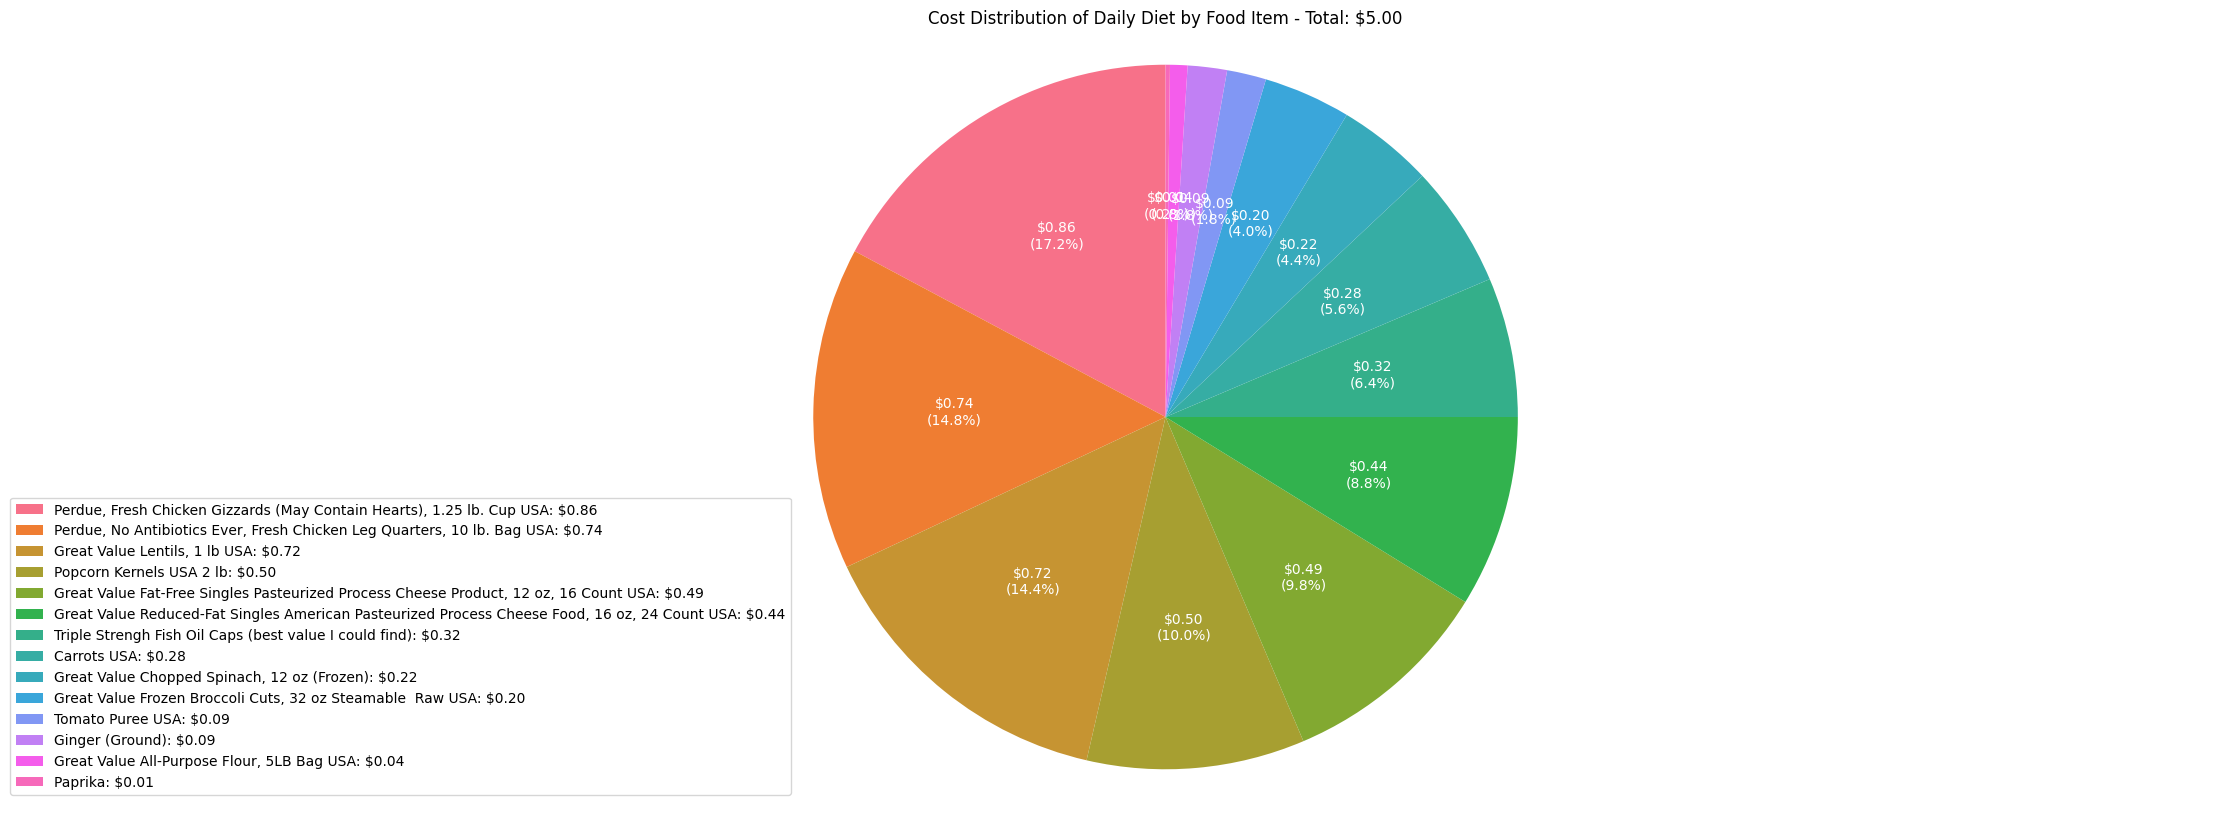

In [188]:
# Solve the optimization problem
status = maintenance_model.solve()

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Food Name', 'Quantity (g)', 'Category', 'is Pill'])

# Collect the data for the DataFrame
results_list = [{'Food Name': name_per_food[i-1], 'Category': category_per_food[i-1],'is Pill': is_pill_per_food[i-1], 'Quantity (g)': int(round(var.value(), 0))} for i, var in x.items() if var.value() > 0]

# Convert the list to a DataFrame and sort
results_df = pd.DataFrame(results_list).sort_values(by='Quantity (g)', ascending=False)


# Calculate the cost for each food type and add it as a new column
results_df['Cost ($)'] = 0.0  # Initialize the column

for index, row in results_df.iterrows():
    product_name = row['Food Name']
    quantity = row['Quantity (g)']
    is_pill = row['is Pill']
    
    # Find the corresponding row in df_filtered
    matched_row = df_filtered[df_filtered['Product Name'] == product_name]
    
    if not matched_row.empty:
        price_per_unit = matched_row['Price / kg'].values[0]
        
        if is_pill == 1:
            # Calculate cost for pills
            cost = price_per_unit * (round(quantity / 100,0))  # quantity / 100 as it's in caps already
        else:
            # Calculate cost for non-pill items
            cost = (price_per_unit * quantity) / 1000  # quantity in grams
        
        results_df.at[index, 'Cost ($)'] = round(cost, 2)

# Move 'Supplements' category to the end
supplements_df = results_df[results_df['Category'] == 'Supplements']
other_categories_df = results_df[results_df['Category'] != 'Supplements']

# Concatenate both parts, ensuring 'Supplements' is at the end
results_df = pd.concat([other_categories_df, supplements_df])

# Get the results and format them
print(f"status: {maintenance_model.status}, {LpStatus[maintenance_model.status]}")
objective_value = round(results_df['Cost ($)'].sum(), 2)
monthly_cost = round(results_df['Cost ($)'].sum() * 30, 2)
print(f"TOTAL COST OF DAILY DIET CALCULATED:\t${objective_value}")
print(f"TOTAL COST OF MONTHLY DIET CALCULATED:\t${monthly_cost}")

# Display the results DataFrame
print("\nCONSISTING OF THE FOLLOWING FOODS:")
for index, row in results_df.iterrows():
    food_name = row['Food Name']
    if row['is Pill'] == 1:
        quantity = f"{int(round(row['Quantity (g)'] / 100, 0))} caps"
    else:
        quantity = f"{int(row['Quantity (g)'])} g"
    cost = f"${row['Cost ($)']:.2f}"
    category = row['Category']
    print(f"{food_name.ljust(95)}: {quantity.ljust(20)}{cost.ljust(10)}{category}")

#Visualization

# Ensure the pie chart is in the correct order
results_df = results_df.sort_values(by='Cost ($)', ascending=False)

# Calculate rounded total
rounded_total = round(results_df['Cost ($)'].sum(), 2)

# Plotting
plt.figure(figsize=(10, 10))

# Generate colors
colors = sns.color_palette('husl', len(results_df))

# Create pie chart
wedges, texts, autotexts = plt.pie(results_df['Cost ($)'], labels=results_df['Food Name'], startangle=90, colors=colors,
                                   autopct=lambda pct: f"${results_df['Cost ($)'].sum() * pct / 100:.2f}\n({pct:.1f}%)",
                                   textprops=dict(color="w"))

# Equal aspect ratio ensures the pie chart is a circle
plt.axis('equal')  
plt.title(f'Cost Distribution of Daily Diet by Food Item - Total: ${rounded_total:.2f}')

# Adding legend with text and cost
legend_labels = [f"{results_df.iloc[i]['Food Name']}: ${results_df.iloc[i]['Cost ($)']:.2f}" for i in range(len(results_df))]
plt.legend(wedges, legend_labels, loc='lower left', bbox_to_anchor=(-1, 0))

plt.show()


In [189]:

# Print errors per constraint equation
print("\nERROR PER CONSTRAINT EQUATION:")
for name, constraint in maintenance_model.constraints.items():
    # Replace underscores with spaces
    name_with_spaces = name.replace('_', ' ')

    # Determine the operator and RHS value
    if "Lower" in name:
        operator = '>='
        rhs_value = -constraint.constant
    elif "Upper" in name:
        operator = '<='
        rhs_value = -constraint.constant
    elif "Minimum" in name:
        operator = '>='
        rhs_value = -constraint.constant
    elif "Equality" in name:
        operator = '=='
        rhs_value = -constraint.constant
    elif "Maximum" in name:
        operator = '<='
        rhs_value = -constraint.constant

    # Calculate the left-hand side value
    lhs_value = sum(var.value() * coeff for var, coeff in constraint.items())

    # Round the lhs_value and rhs_value to the nearest integer
    lhs_value_rounded = round(lhs_value)
    rhs_value_rounded = round(rhs_value)

    # Calculate the error and round to three significant figures
    constraint_value_rounded = round(abs(lhs_value - rhs_value), 2)

    # Format the output
    if constraint_value_rounded >= 0.1:
        print(f"{name_with_spaces.ljust(55)}\t{lhs_value_rounded}\t{operator}\t{rhs_value_rounded},\t{constraint_value_rounded}")
    else:
        print(f"{name_with_spaces.ljust(55)}\t{lhs_value_rounded}\t{operator}\t{rhs_value_rounded}")


ERROR PER CONSTRAINT EQUATION:
Maintenance Calories Equality Constraint               	2929	==	2929
Protein Minimum Constraint                             	242	>=	242
Net Carb Minimum Constraint                            	296	>=	234,	61.17
Fiber Lower Bound Constraint                           	60	>=	30,	30.0
Fiber Upper Bound Constraint                           	60	<=	60
Fat Lower Bound Constraint                             	81	>=	81
Fat Upper Bound Constraint                             	81	<=	114,	32.55
Protein Quality Minimum Constraint                     	78	>=	0,	77.92
Sugar Maximum Constraint                               	8	<=	75,	67.24
SatFat Maximum Constraint                              	-24	<=	0,	24.07
Calcium Lower Bound Constraint                         	1500	>=	1500
Calcium Upper Bound Constraint                         	1500	<=	2000,	500.0
Iron Lower Bound Constraint                            	40	>=	30,	10.0
Iron Upper Bound Constraint                           

In [190]:
# Create a new DataFrame to store the calculated values
results_calculated = pd.DataFrame()

# Loop through the results list and perform the calculations
for result in results_list:
    product_name = result['Food Name']
    quantity = result['Quantity (g)']
    
    # Find the corresponding row in df_filtered
    matched_row = df_filtered[df_filtered['Product Name'] == product_name].copy()
    
    # Calculate 'Cost ($)'
    if matched_row['is Pill'].values[0] == 1:
        matched_row['Cost ($)'] = (quantity / 100) * matched_row['Price / kg']
        matched_row['Quantity (g)'] = round(quantity / 100) * 100  # Round to nearest 100 for pills
    else:
        matched_row['Cost ($)'] = quantity / 1000 * matched_row['Price / kg']
        matched_row['Quantity (g)'] = quantity  # No rounding for regular foods
    
    # Select columns before column index 98 for calculations
    numeric_cols_before_98 = matched_row.columns[:98]
    
    # Create a DataFrame to store the calculated values for numeric columns before column 100
    calculated_values = matched_row[numeric_cols_before_98].copy()

    # Only multiply numeric columns
    for col in calculated_values.columns:
        if col not in ['Cost ($)', 'Quantities (g)', 'Price / kg'] and pd.api.types.is_numeric_dtype(calculated_values[col]):
            calculated_values[col] = calculated_values[col] * (quantity / 100)
    
    # Select columns from column index 98 onward without modification
    cols_from_98_onward = matched_row.columns[98:]
    non_calculated_values = matched_row[cols_from_98_onward]
    
    # Concatenate both parts to get the final row for this product
    final_row = pd.concat([calculated_values, non_calculated_values], axis=1)
    
    # Append the final row to the results_calculated DataFrame
    results_calculated = pd.concat([results_calculated, final_row], axis=0)

# Reset index for the final results_calculated DataFrame
results_calculated.reset_index(drop=True, inplace=True)

# Calculate the sum for each numeric column and create a final row
sum_row = results_calculated.sum(numeric_only=True).to_frame().T

# Add a label for the sum row (e.g., "Total")
sum_row['Product Name'] = 'Total'

# Append the sum row to the results_calculated DataFrame
results_calculated = pd.concat([results_calculated, sum_row], ignore_index=True)

# Display the results DataFrame
print("\nCONSISTING OF THE FOLLOWING FOODS:")
for index, row in results_calculated.iterrows():
    food_name = row['Product Name']
    if row['is Pill'] == 1:
        quantity = f"{int(round(row['Quantity (g)'] / 100, 0))} caps"
    else:
        quantity = f"{int(row['Quantity (g)'])} g"
    cost = f"${row['Cost ($)']:.2f}"
    category = row['Category']
    print(f"{food_name.ljust(95)}: {quantity.ljust(20)}{cost.ljust(10)}{category}")

# Display the final DataFrame
print("\nCALCULATED NUTRITIONAL VALUES:")
print(results_calculated)



CONSISTING OF THE FOLLOWING FOODS:
Great Value All-Purpose Flour, 5LB Bag USA                                                     : 38 g                $0.04     Grains and Pasta
Great Value Chopped Spinach, 12 oz (Frozen)                                                    : 64 g                $0.22     Vegetables
Great Value Frozen Broccoli Cuts, 32 oz Steamable  Raw USA                                     : 79 g                $0.20     Vegetables
Carrots USA                                                                                    : 128 g               $0.28     Vegetables
Tomato Puree USA                                                                               : 51 g                $0.09     Vegetables
Great Value Fat-Free Singles Pasteurized Process Cheese Product, 12 oz, 16 Count USA           : 85 g                $0.49     Dairy and Egg Products
Great Value Reduced-Fat Singles American Pasteurized Process Cheese Food, 16 oz, 24 Count USA  : 84 g                $

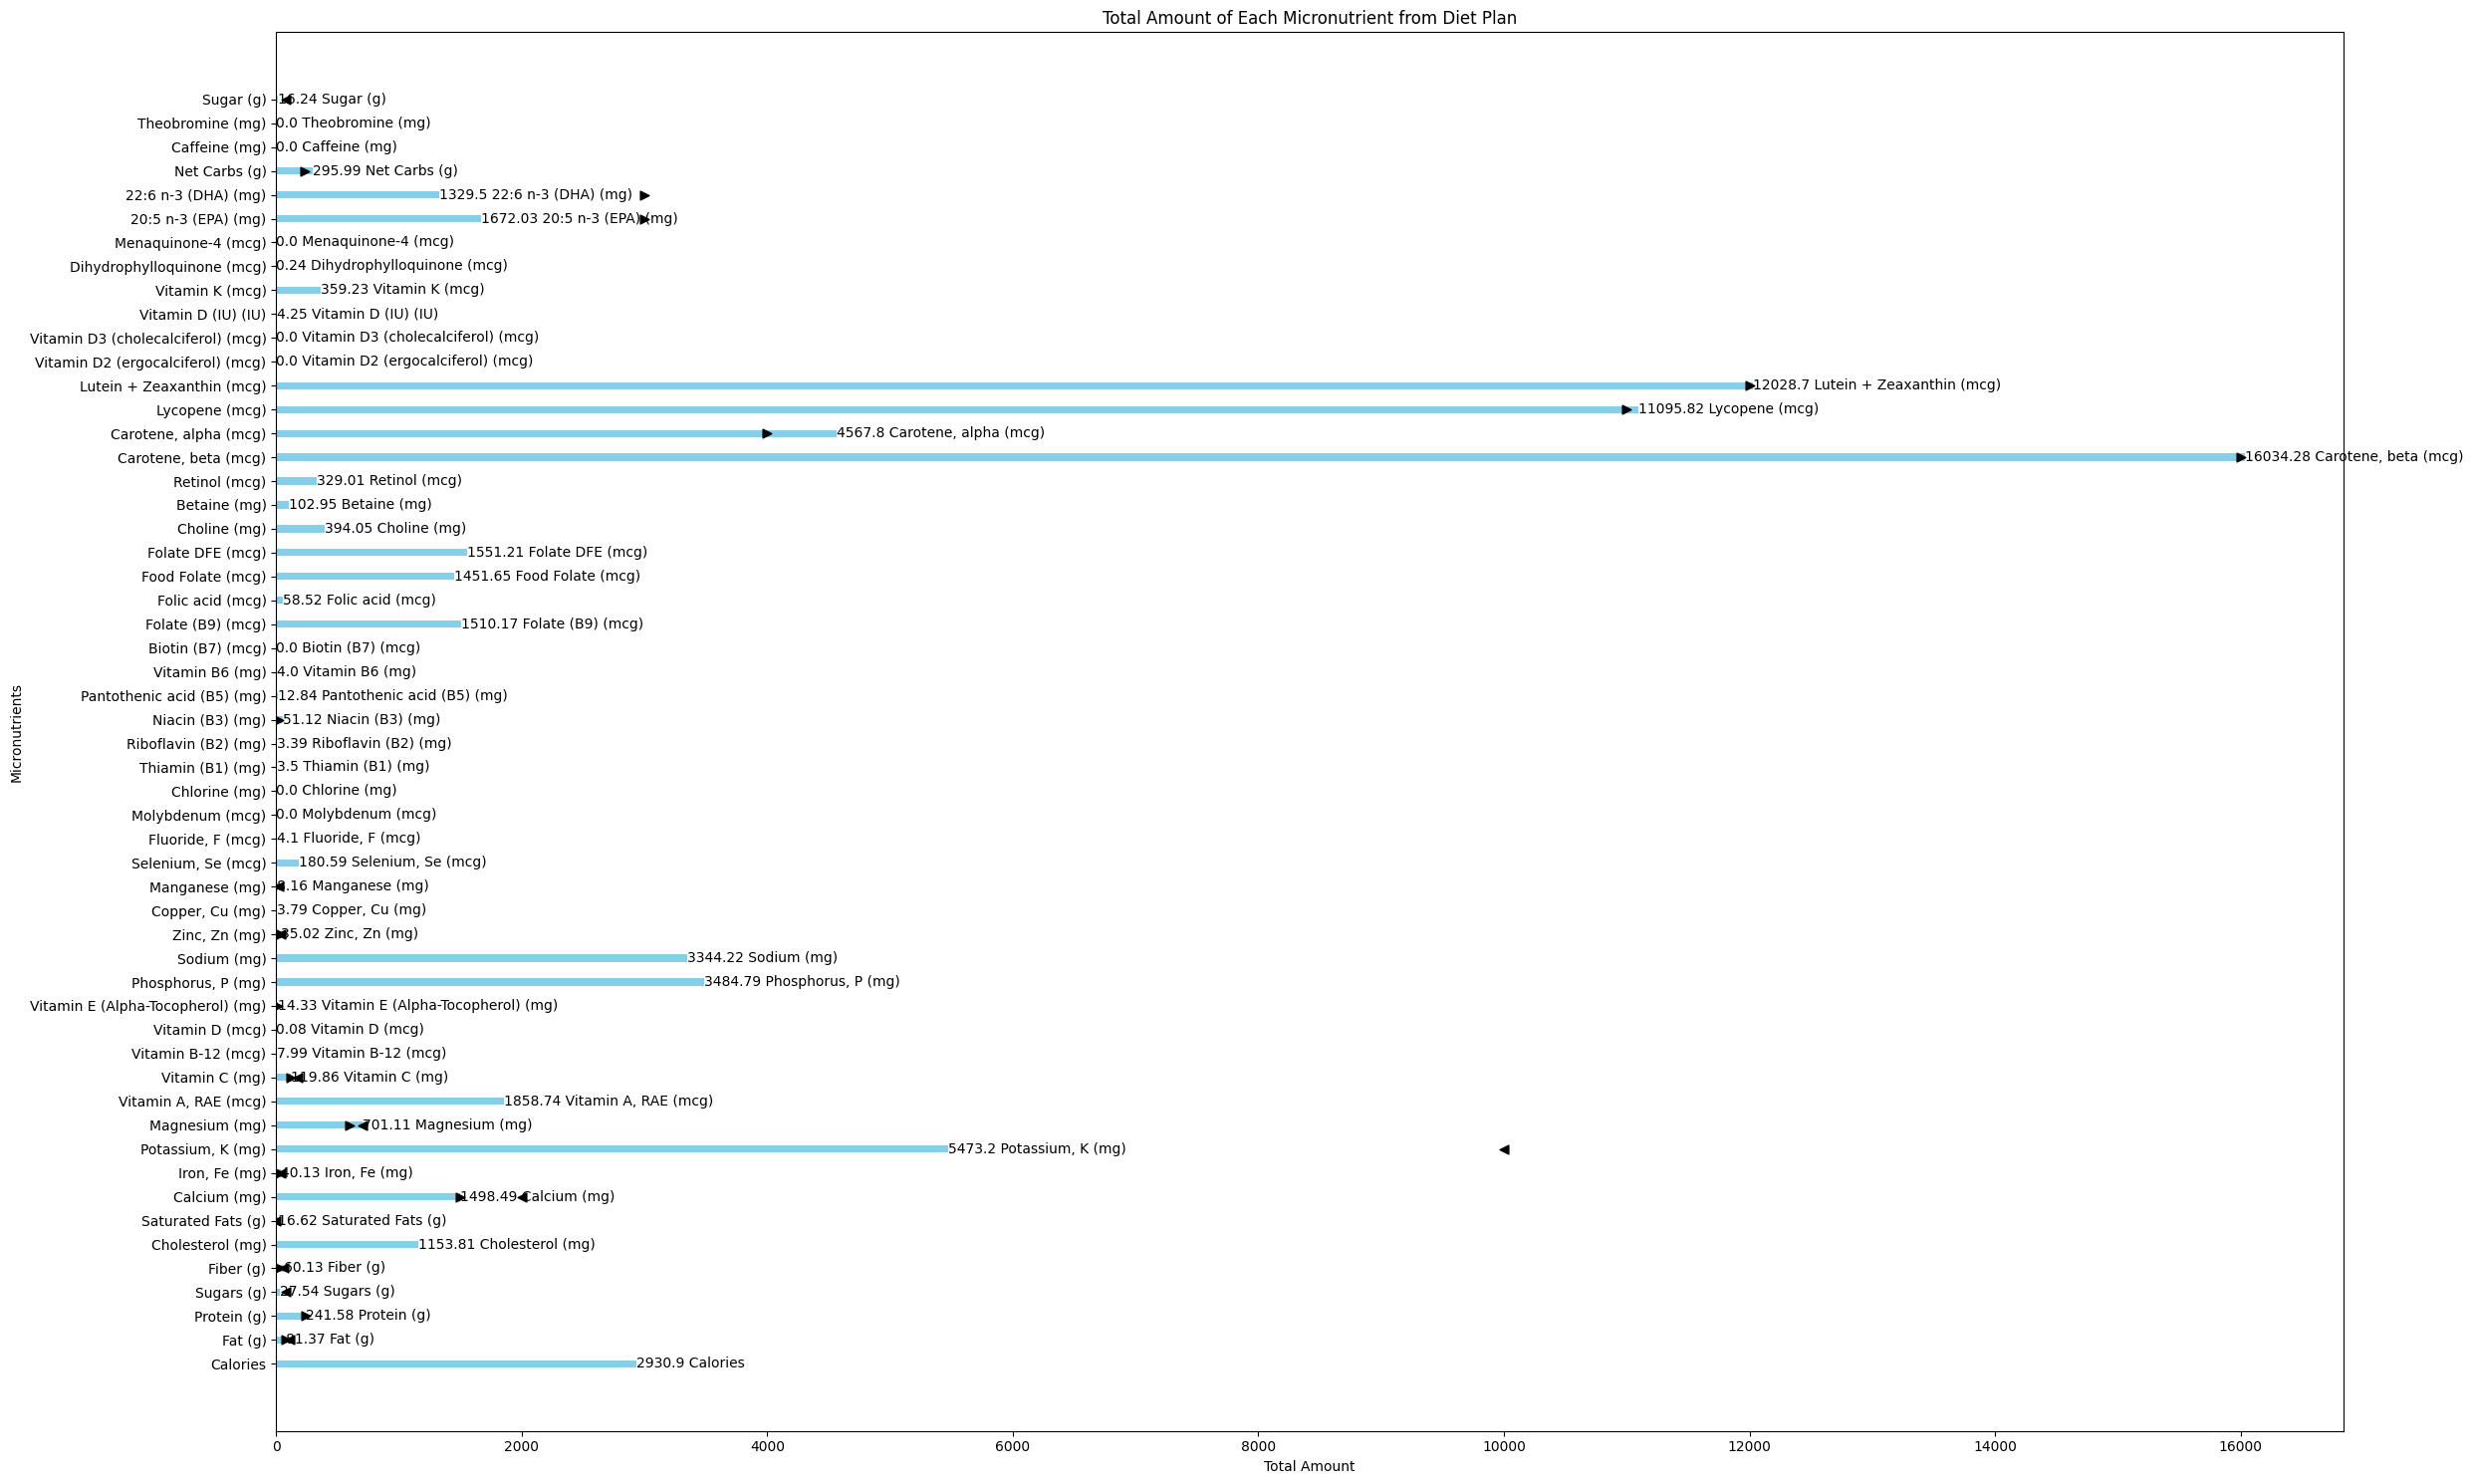

In [191]:
# Define the list of columns to be graphed
columns_to_graph = [
    'Calories', 'Fat (g)', 'Protein (g)', 'Sugars (g)', 'Fiber (g)', 'Cholesterol (mg)', 'Saturated Fats (g)', 
    'Calcium (mg)', 'Iron, Fe (mg)', 'Potassium, K (mg)', 'Magnesium (mg)', 
    #'Vitamin A, IU (IU)', 
    'Vitamin A, RAE (mcg)', 'Vitamin C (mg)', 'Vitamin B-12 (mcg)', 'Vitamin D (mcg)', 
    'Vitamin E (Alpha-Tocopherol) (mg)', 'Phosphorus, P (mg)', 'Sodium (mg)', 'Zinc, Zn (mg)', 'Copper, Cu (mg)', 
    'Manganese (mg)', 'Selenium, Se (mcg)', 'Fluoride, F (mcg)', 'Molybdenum (mcg)', 'Chlorine (mg)', 
    'Thiamin (B1) (mg)', 'Riboflavin (B2) (mg)', 'Niacin (B3) (mg)', 'Pantothenic acid (B5) (mg)', 'Vitamin B6 (mg)', 
    'Biotin (B7) (mcg)', 'Folate (B9) (mcg)', 'Folic acid (mcg)', 'Food Folate (mcg)', 'Folate DFE (mcg)', 
    'Choline (mg)', 'Betaine (mg)', 'Retinol (mcg)', 'Carotene, beta (mcg)', 'Carotene, alpha (mcg)', 
    'Lycopene (mcg)', 'Lutein + Zeaxanthin (mcg)', 'Vitamin D2 (ergocalciferol) (mcg)', 'Vitamin D3 (cholecalciferol) (mcg)', 
    'Vitamin D (IU) (IU)', 'Vitamin K (mcg)', 'Dihydrophylloquinone (mcg)', 'Menaquinone-4 (mcg)', 
    '20:5 n-3 (EPA) (mg)', '22:6 n-3 (DHA) (mg)', 'Net Carbs (g)', 'Caffeine (mg)', 'Theobromine (mg)',  'Sugar (g)'
]

# Extract the last row (totals row) of the results_calculated DataFrame
totals_row = results_calculated.iloc[-1]

# Filter the totals row to get the values for the specified columns
totals_values = totals_row[columns_to_graph]

# Plot the horizontal bar chart
plt.figure(figsize=(25, 15))  # Increase the figure size for better readability
bars = plt.barh(columns_to_graph, totals_values, color='skyblue', height=0.3)  # Adjust the height to make bars skinnier

# Add labels to the bars
for bar, column_name in zip(bars, columns_to_graph):
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, f'{round(xval, 2)} {column_name}', ha='left', va='center')

# Add labels and title
plt.ylabel('Micronutrients')
plt.xlabel('Total Amount')
plt.title('Total Amount of Each Micronutrient from Diet Plan')

# Draw constraint lines and markers
constraints = {
    'Calories': None,
    'Fat (g)': ( fat_lbound,fat_ubound),
    'Protein (g)': (protein_minimum, None),
    'Sugars (g)': (None, sugar_maximum),
    'Fiber (g)': (fiber_lbound, fiber_ubound),
    'Cholesterol (mg)': None,
    'Saturated Fats (g)': (None, sat_fat_maximum),
    'Calcium (mg)': (calcium_lbound, calcium_ubound),
    'Iron, Fe (mg)': (iron_lbound, iron_ubound),
    'Potassium, K (mg)': (None, potassium_maximum),
    'Magnesium (mg)': (magnesium_lbound, magnesium_ubound),
    'Vitamin A, IU (IU)': None,
    'Vitamin A, RAE (mcg)': None,
    'Vitamin C (mg)': (vitaminC_lbound, vitaminC_ubound),
    'Vitamin B-12 (mcg)': None,
    'Vitamin D (mcg)': None,
    'Vitamin E (Alpha-Tocopherol) (mg)': (vitaminE_minimum, None),
    'Phosphorus, P (mg)': None,
    'Sodium (mg)': None,
    'Zinc, Zn (mg)': (zinc_lbound, zinc_ubound),
    'Copper, Cu (mg)': None,
    'Manganese (mg)': (manganese_lbound, manganese_ubound),
    'Selenium, Se (mcg)': None,
    'Fluoride, F (mcg)': None,
    'Molybdenum (mcg)': None,
    'Chlorine (mg)': None,
    'Thiamin (B1) (mg)': None,
    'Riboflavin (B2) (mg)': None,
    'Niacin (B3) (mg)': (niacin_minimum, None),
    'Pantothenic acid (B5) (mg)': None,
    'Vitamin B6 (mg)': None,
    'Biotin (B7) (mcg)': None,
    'Folate (B9) (mcg)': None,
    'Folic acid (mcg)': None,
    'Food Folate (mcg)': None,
    'Folate DFE (mcg)': None,
    'Choline (mg)': None,
    'Betaine (mg)': None,
    'Retinol (mcg)': None,
    'Carotene, beta (mcg)': (beta_carotene_minimum, None),
    'Carotene, alpha (mcg)': (alpha_carotene_minimum, None),
    'Lycopene (mcg)': (lycopene_minimum, None),
    'Lutein + Zeaxanthin (mcg)': (lut_zeaxanthin_minimum, None),
    'Vitamin D2 (ergocalciferol) (mcg)': None,
    'Vitamin D3 (cholecalciferol) (mcg)': None,
    'Vitamin D (IU) (IU)': None,
    'Vitamin K (mcg)': None,
    'Dihydrophylloquinone (mcg)': None,
    'Menaquinone-4 (mcg)': None,
    '20:5 n-3 (EPA) (mg)': (Fish_Oils_minimum, None),
    '22:6 n-3 (DHA) (mg)': (Fish_Oils_minimum, None),
    'Net Carbs (g)': (net_carb_minimum, None),
    'Caffeine (mg)': None,
    'Theobromine (mg)': None,
    'Sugar (g)': (None, sugar_maximum)
}

for column_name, constraints in constraints.items():
    if constraints:
        min_constraint, max_constraint = constraints
        if min_constraint is not None:
            plt.scatter(min_constraint, columns_to_graph.index(column_name), color='black', marker='>', s=40, alpha=1)
        if max_constraint is not None:
            plt.scatter(max_constraint, columns_to_graph.index(column_name), color='black', marker='<', s=40, alpha=1)

# Adjust layout to avoid clipping
plt.tight_layout()

# Show plot
plt.show()


In [192]:
# Print all column names of the results_calculated DataFrame
print("Column names in the results_calculated DataFrame:")
print(results_calculated.columns.tolist())

Column names in the results_calculated DataFrame:
['Cost ($)', 'Quantities (g)', 'ID', 'name', 'Category', 'Calories', 'Fat (g)', 'Protein (g)', 'Carbohydrate (g)', 'Sugars (g)', 'Fiber (g)', 'Cholesterol (mg)', 'Saturated Fats (g)', 'Calcium (mg)', 'Iron, Fe (mg)', 'Potassium, K (mg)', 'Magnesium (mg)', 'Vitamin A, IU (IU)', 'Vitamin A, RAE (mcg)', 'Vitamin C (mg)', 'Vitamin B-12 (mcg)', 'Vitamin D (mcg)', 'Vitamin E (Alpha-Tocopherol) (mg)', 'Net-Carbs (g)', 'Water (g)', 'Omega 3s (mg)', 'Omega 6s (mg)', 'PRAL score', 'Trans Fatty Acids (g)', 'Sucrose (g)', 'Glucose (Dextrose) (g)', 'Fructose (g)', 'Lactose (g)', 'Maltose (g)', 'Galactose (g)', 'Starch (g)', 'Total sugar alcohols (g)', 'Phosphorus, P (mg)', 'Sodium (mg)', 'Zinc, Zn (mg)', 'Copper, Cu (mg)', 'Manganese (mg)', 'Selenium, Se (mcg)', 'Fluoride, F (mcg)', 'Molybdenum (mcg)', 'Chlorine (mg)', 'Thiamin (B1) (mg)', 'Riboflavin (B2) (mg)', 'Niacin (B3) (mg)', 'Pantothenic acid (B5) (mg)', 'Vitamin B6 (mg)', 'Biotin (B7) (mcg)

In [193]:

#Debugger cell
#protein_quality = df_filtered.iloc[:, 101].values

print (len(protein_quality))
print(is_pill_per_food)
results_calculated.info()

41
[0 0 0 0 0 0 0 0 0 0 'N' 'N' 'N' 'N' 'N' 'N' 0 0 0 'N' 'N' 'N' 'N' 0 0 0
 'N' 'N' 0 0 0 'N' 0 0 0 0 0 0 0 0 1.0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Columns: 108 entries, Cost ($) to Quantity (g)
dtypes: float64(101), object(7)
memory usage: 12.8+ KB


# Thoughts

Iodine data is missing. not a big deal, there is a USDA database where they measured iodine amounts for 467 foods, but the ID columns dont match, I could do somesort of index match fuzzy search, but iodine isn't that important. dont have much recommendations other than don't exceed 600 mcg.

The RDAs of some micros are kinda misleading. Let's say calcium's RDA is 1000 mg, but calcium from dairy is absorbed at 80% efficiency, and from spinach it's 20%. Therefore there will be a big difference in absorption between the same amount of calcium but different food choices.
A way to fix this would be to scale the mg of the nutrient of each food group by it's absorption rate, and then use this 'apples to apples' metric. But you would need to determine a new RDA based on this metric, and then actual absorption is affected by other micros and compounds in a food / a meal (ie, vitamin C improves the absorption of iron), so it gets very complicated..

# TODO:
Program carve-outs (like if I want a specific intraworkout drink with specific macros and micros, include it separate as stand-alone, and subtract its info from the rest of the daily diet)

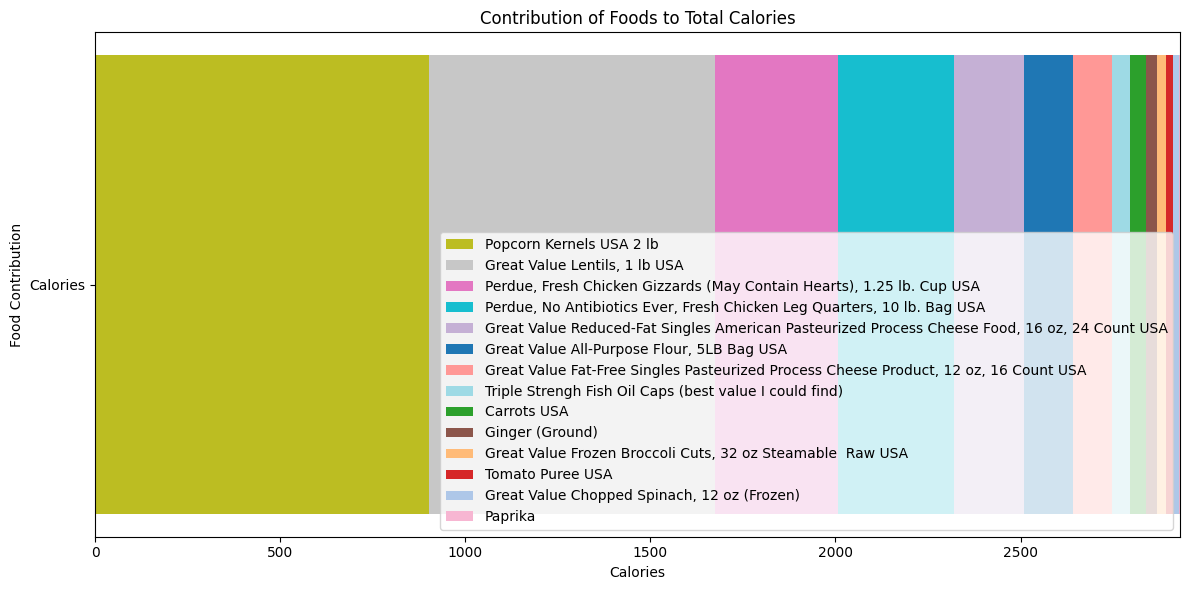

In [194]:
# Filter out the 'Total' row
results_calculated = results_calculated[results_calculated['Product Name'] != 'Total']

# Calculate total calories
total_calories = results_calculated['Calories'].sum()

# Calculate percentage contribution
results_calculated['Contribution (%)'] = results_calculated['Calories'] / total_calories * 100

# Sort by contribution to plot largest first
results_calculated = results_calculated.sort_values(by='Contribution (%)', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))  # Adjust size as needed

# Plot the single horizontal bar for Calories
bars = plt.barh('Calories', total_calories, color='lightgrey')

# Generate unique colors for each food item
num_foods = len(results_calculated)
cmap = plt.get_cmap('tab20', num_foods)  # Using a colormap with dynamically selected number of colors

# Accumulate the left position for each bar
left = 0

# Plot each food's contribution as a colored segment
for idx, row in results_calculated.iterrows():
    contribution = row['Calories']
    color = cmap(idx % num_foods)  # Get a unique color from the colormap
    plt.barh('Calories', contribution, left=left, color=color, label=row['Product Name'] if pd.notna(row['Product Name']) else None)
    left += contribution  # Accumulate the left position

# Add labels and title
plt.xlabel('Calories')
plt.ylabel('Food Contribution')
plt.title('Contribution of Foods to Total Calories')

# Adding legend
handles, labels = plt.gca().get_legend_handles_labels()
filtered_labels = [label for label in labels if label and label != 'Total']
plt.legend(handles, filtered_labels, loc='lower right')

# Set x-axis limits to total calories
plt.xlim(0, total_calories)

# Show plot
plt.tight_layout()
plt.show()


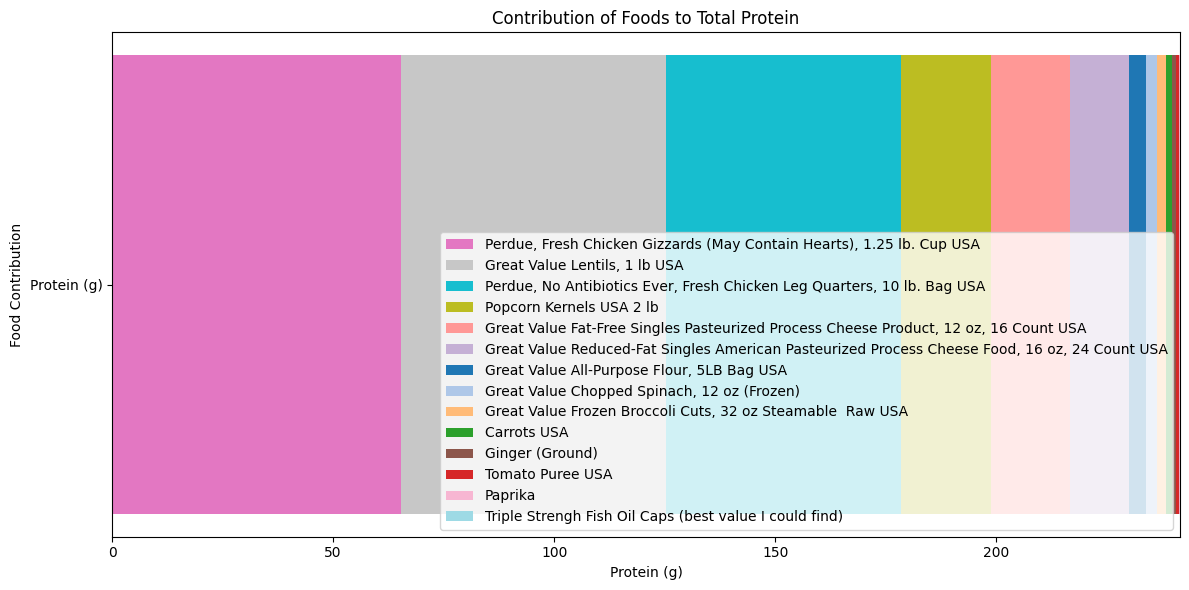

In [195]:
# Assuming results_calculated is your DataFrame with a column 'Product Name' and 'Protein (g)'

# Filter out the 'Total' row
results_calculated = results_calculated[results_calculated['Product Name'] != 'Total']

# Calculate total protein
total_protein = results_calculated['Protein (g)'].sum()

# Calculate percentage contribution
results_calculated['Contribution (%)'] = results_calculated['Protein (g)'] / total_protein * 100

# Sort by contribution to plot largest first
results_calculated = results_calculated.sort_values(by='Contribution (%)', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))  # Adjust size as needed

# Plot the single horizontal bar for Protein
bars = plt.barh('Protein (g)', total_protein, color='lightgrey')

# Generate unique colors for each food item
num_foods = len(results_calculated)
cmap = plt.get_cmap('tab20', num_foods)  # Using a colormap with dynamically selected number of colors

# Accumulate the left position for each bar
left = 0

# Plot each food's contribution as a colored segment
for idx, row in results_calculated.iterrows():
    contribution = row['Protein (g)']
    color = cmap(idx % num_foods)  # Get a unique color from the colormap
    plt.barh('Protein (g)', contribution, left=left, color=color, label=row['Product Name'] if pd.notna(row['Product Name']) else None)
    left += contribution  # Accumulate the left position

# Add labels and title
plt.xlabel('Protein (g)')
plt.ylabel('Food Contribution')
plt.title('Contribution of Foods to Total Protein')

# Adding legend
handles, labels = plt.gca().get_legend_handles_labels()
filtered_labels = [label for label in labels if label and label != 'Total']
plt.legend(handles, filtered_labels, loc='lower right')

# Set x-axis limits to total protein
plt.xlim(0, total_protein)

# Show plot
plt.tight_layout()
plt.show()

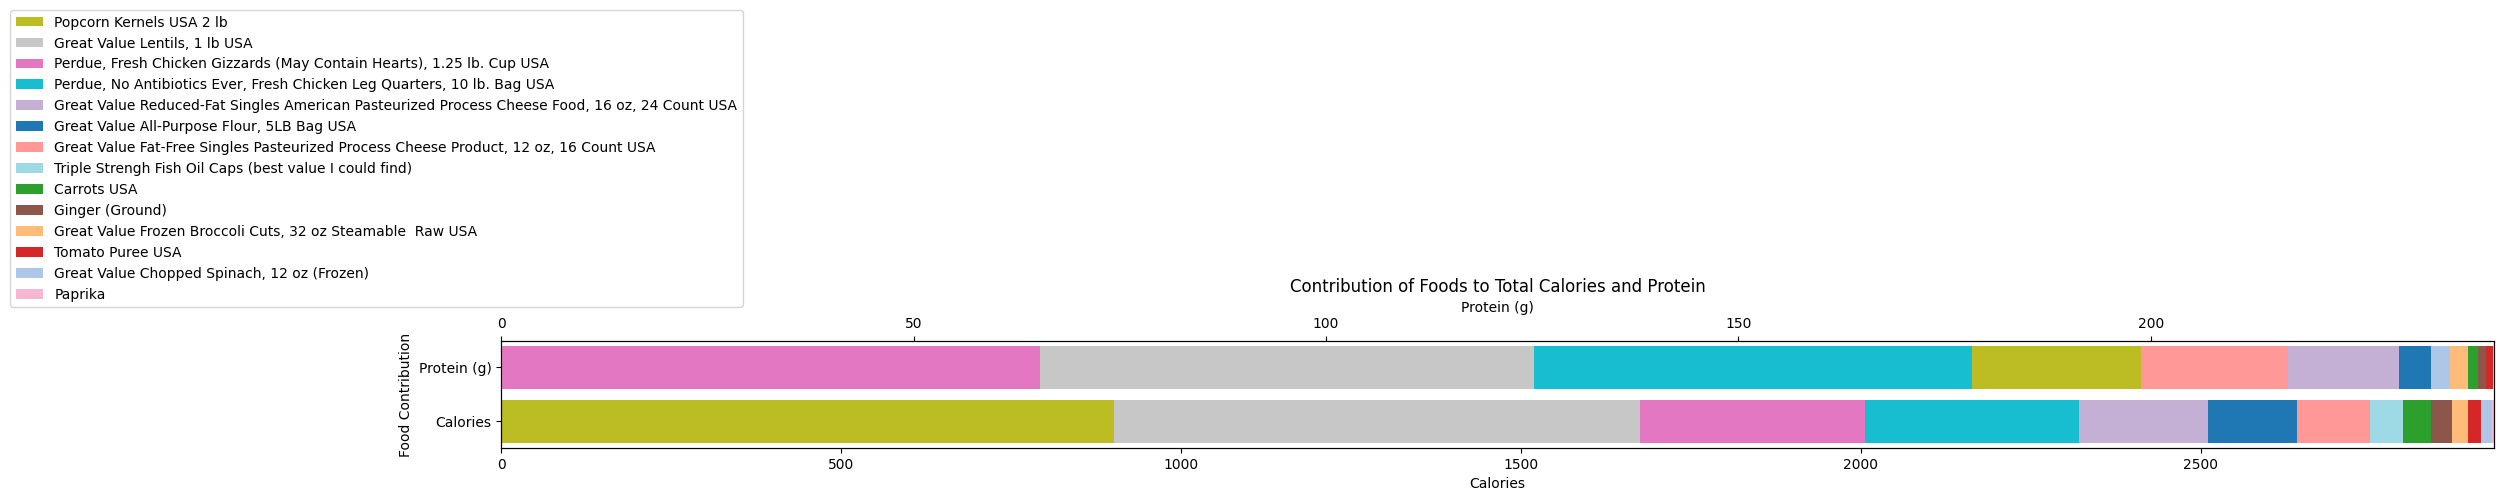

In [196]:
# Filter out the 'Total' row
results_calculated = results_calculated[results_calculated['Product Name'] != 'Total']

# Calculate total calories and protein
total_calories = results_calculated['Calories'].sum()
total_protein = results_calculated['Protein (g)'].sum()

# Calculate percentage contributions
results_calculated['Calorie Contribution (%)'] = results_calculated['Calories'] / total_calories * 100
results_calculated['Protein Contribution (%)'] = results_calculated['Protein (g)'] / total_protein * 100

# Sort by calorie contribution to plot largest first
results_calculated = results_calculated.sort_values(by='Calorie Contribution (%)', ascending=False)

# Plotting
fig, ax1 = plt.subplots(figsize=(25, 6))  # Adjust size as needed

# Generate unique colors for each food item
num_foods = len(results_calculated)
cmap = plt.get_cmap('tab20', num_foods)  # Using a colormap with dynamically selected number of colors

# Plot each food's contribution to calories as a colored segment
bars_calories = []
left_calories = 0
for idx, row in results_calculated.iterrows():
    contribution = row['Calories']
    color = cmap(idx % num_foods)  # Get a unique color from the colormap
    bar = ax1.barh('Calories', contribution, left=left_calories, color=color, label=row['Product Name'] if pd.notna(row['Product Name']) else None)
    bars_calories.append(bar)
    left_calories += contribution  # Accumulate the left position

# Set x-axis limits to total calories
ax1.set_xlim(0, total_calories)
ax1.set_xlabel('Calories')
ax1.set_ylabel('Food Contribution')

# Create a second y-axis to share the same plot but with a different x-axis for Protein
ax2 = ax1.twiny()

# Sort by protein contribution to plot largest first
results_calculated = results_calculated.sort_values(by='Protein Contribution (%)', ascending=False)

# Plot each food's contribution to protein as a colored segment
bars_protein = []
left_protein = 0
for idx, row in results_calculated.iterrows():
    contribution = row['Protein (g)']
    color = cmap(idx % num_foods)  # Get a unique color from the colormap
    bar = ax2.barh('Protein (g)', contribution, left=left_protein, color=color)
    bars_protein.append(bar)
    left_protein += contribution  # Accumulate the left position

# Set x-axis limits to total protein
ax2.set_xlim(0, total_protein)
ax2.set_xlabel('Protein (g)')

# Add title
plt.title('Contribution of Foods to Total Calories and Protein')

# Adding legend
handles_calories, labels_calories = ax1.get_legend_handles_labels()
handles_protein, labels_protein = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles_calories + handles_protein
labels = labels_calories + labels_protein

# Filter out 'Total' label and None labels
filtered_labels = [label for label in labels if label and label != 'Total' and label != 'None']

# Display legend to the left of the graphLots
ax1.legend(handles, filtered_labels, loc='lower left', bbox_to_anchor=(-0.25, 1.25), frameon=True)

# Show plot
plt.tight_layout()
plt.show()


In [224]:
def PlotContributions(*nutrients):
    # Filter out the 'Total' row
    results_calculated_filtered = results_calculated[results_calculated['Product Name'] != 'Total']
    
    # Calculate total contributions for the selected nutrients
    total_contributions = {}
    for nutrient in nutrients:
        total_contributions[nutrient] = results_calculated_filtered[nutrient].sum()
        results_calculated_filtered[f'{nutrient} Contribution (%)'] = results_calculated_filtered[nutrient] / total_contributions[nutrient] * 100
    
    # Generate unique colors for each food item
    num_foods = len(results_calculated_filtered)
    cmap = plt.get_cmap('tab20', num_foods)  # Using a colormap with dynamically selected number of colors
    colors = [cmap(idx % num_foods) for idx in range(num_foods)]
    
    # Plotting
    fig, axs = plt.subplots(len(nutrients), 1, figsize=(25, 2 * len(nutrients)))  # Create subplots
    
    # Loop through each nutrient and plot its contribution
    for i, nutrient in enumerate(nutrients):
        # Sort and plot each food's contribution to the nutrient as a colored segment
        results_sorted = results_calculated_filtered.sort_values(by=f'{nutrient} Contribution (%)', ascending=False)
        left_position = 0
        for idx, row in results_sorted.iterrows():
            axs[i].barh(nutrient, row[nutrient], left=left_position, color=colors[idx], 
                        label=row['Product Name'] if pd.notna(row['Product Name']) else None, height=0.2)
            left_position += row[nutrient]   # Accumulate the left position with a shorter segment
        
        # Set x-axis limits and labels for the nutrient plot
        axs[i].set_xlim(0, total_contributions[nutrient] )
        axs[i].text(total_contributions[nutrient]*1.005 , nutrient, f'{round(total_contributions[nutrient])}', va='center', ha='left')
    
    # Adding legend to the first subplot
    handles, labels = axs[0].get_legend_handles_labels()
    filtered_labels = [label for label in labels if label and label != 'Total' and label != 'None']
    fig.legend(handles, filtered_labels, loc='lower left', bbox_to_anchor=(-0.25, 1), frameon=True)
    
    # Adjust layout to ensure proper spacing
    plt.tight_layout(rect=[0, 0, 1.5, 1])
    plt.subplots_adjust(hspace=0.5)
    
    # Show plot
    plt.show()
    
    return fig


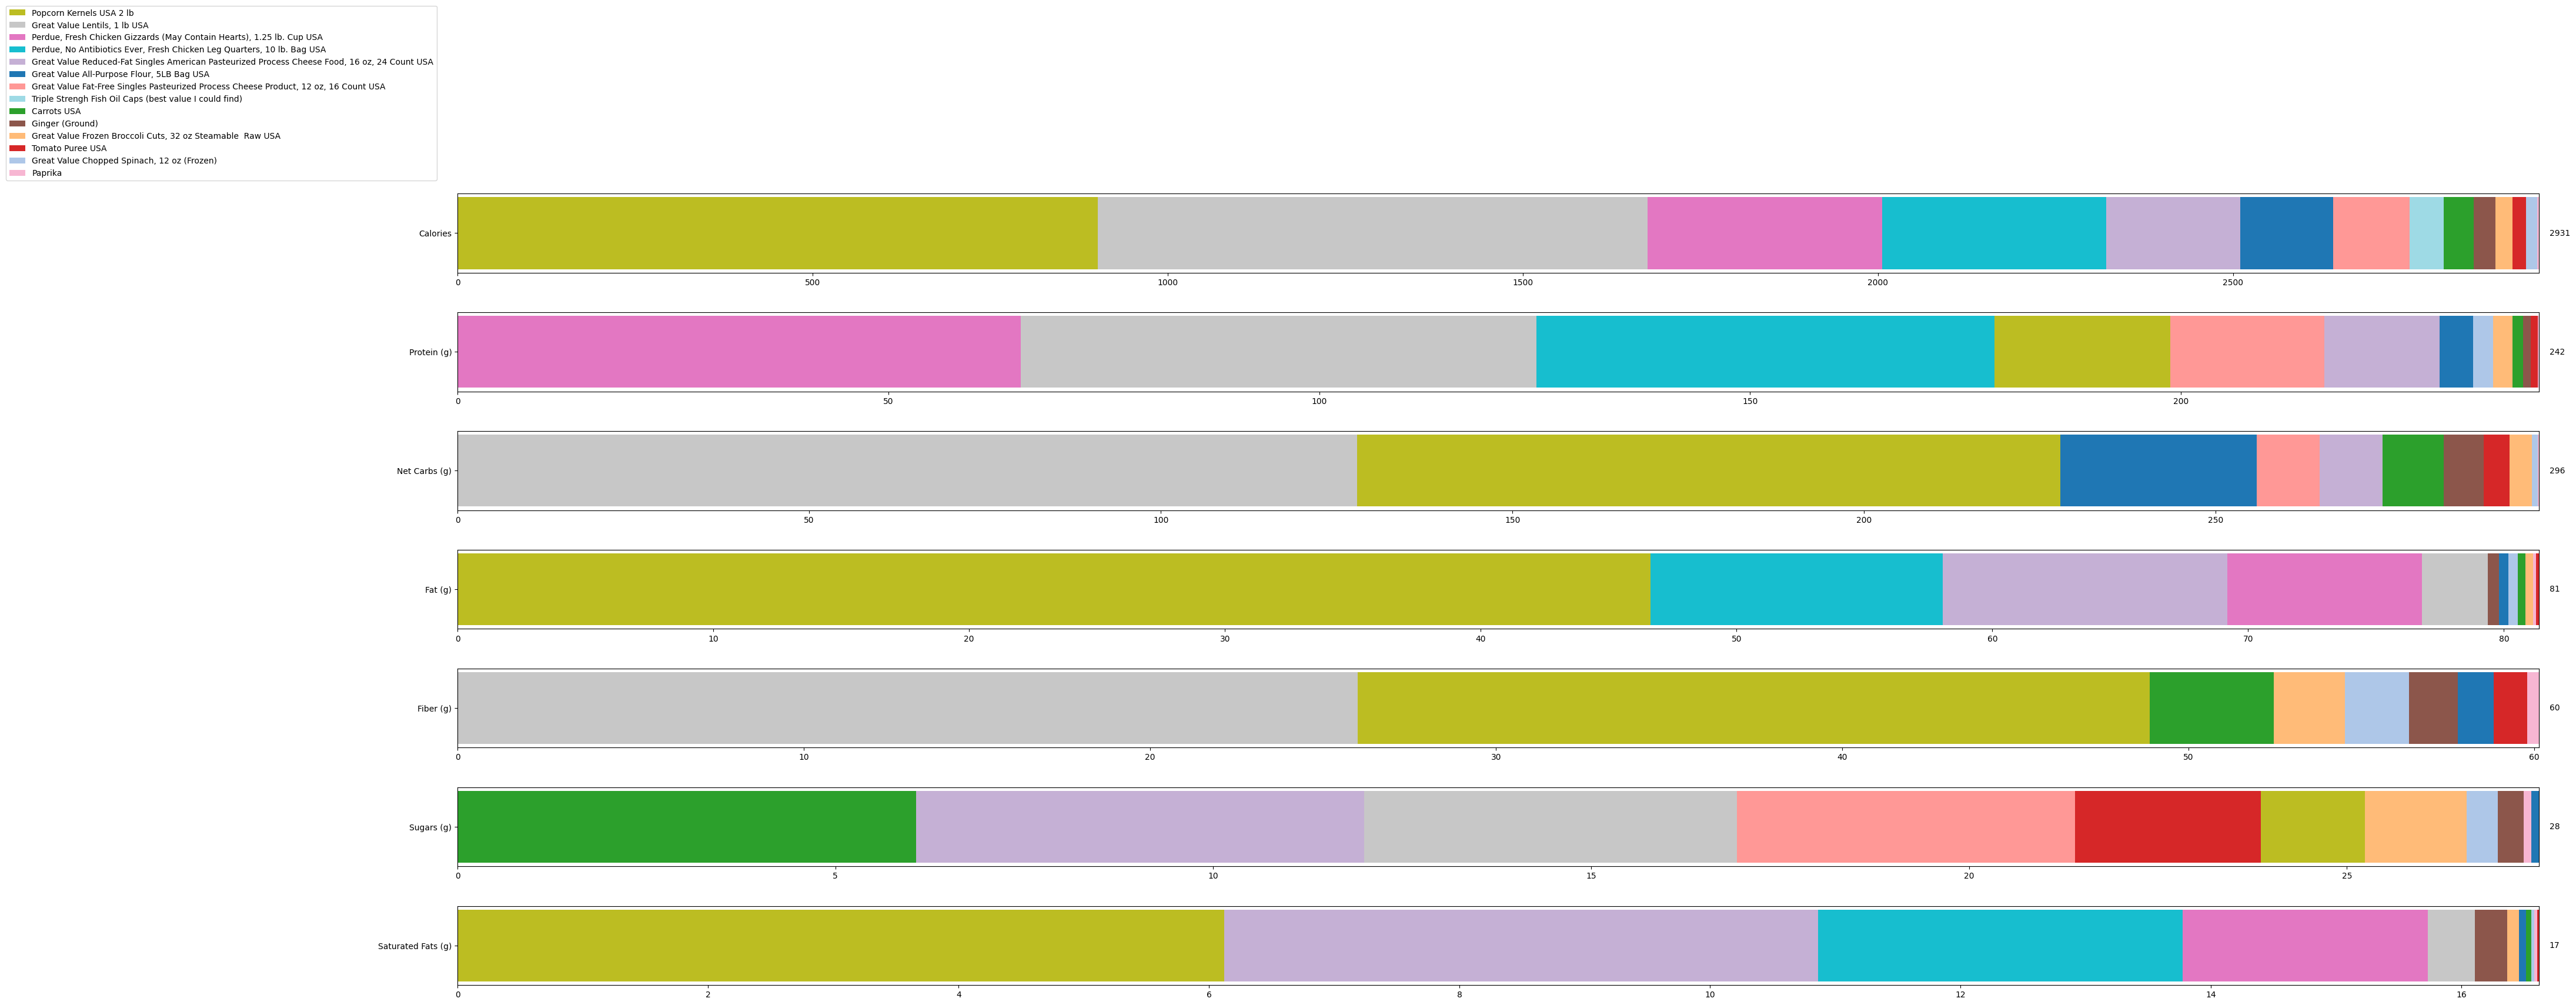

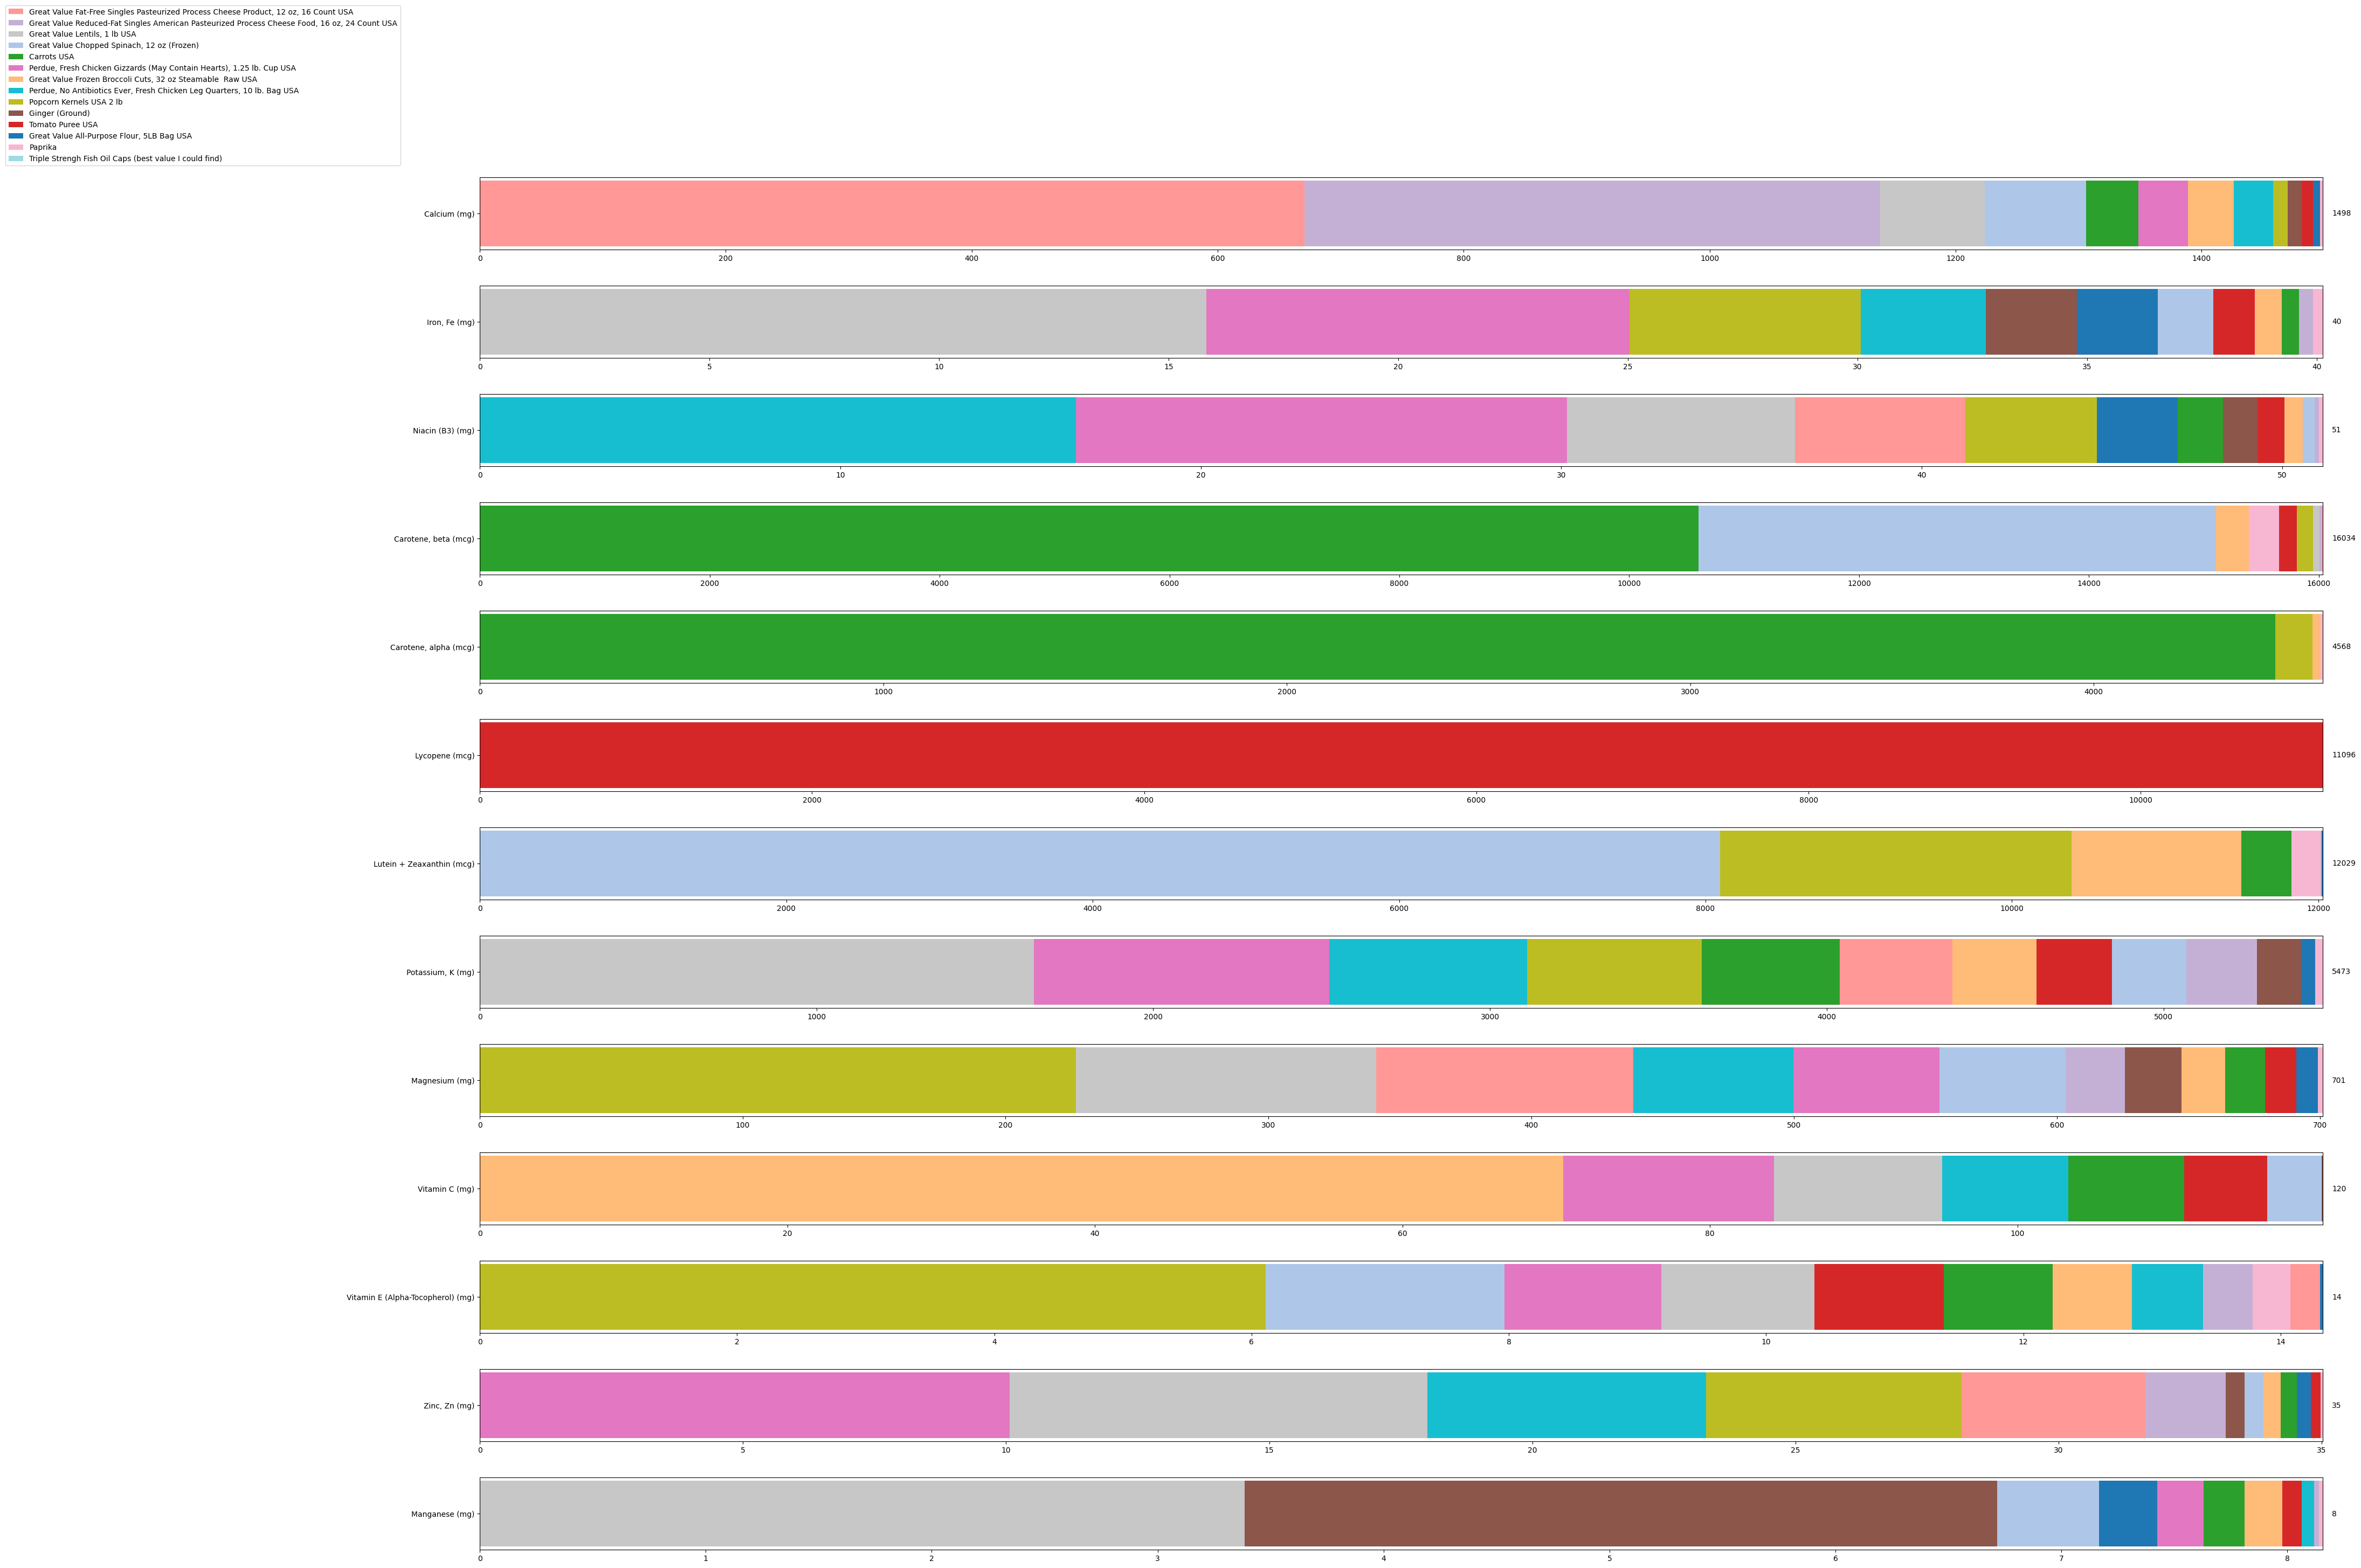

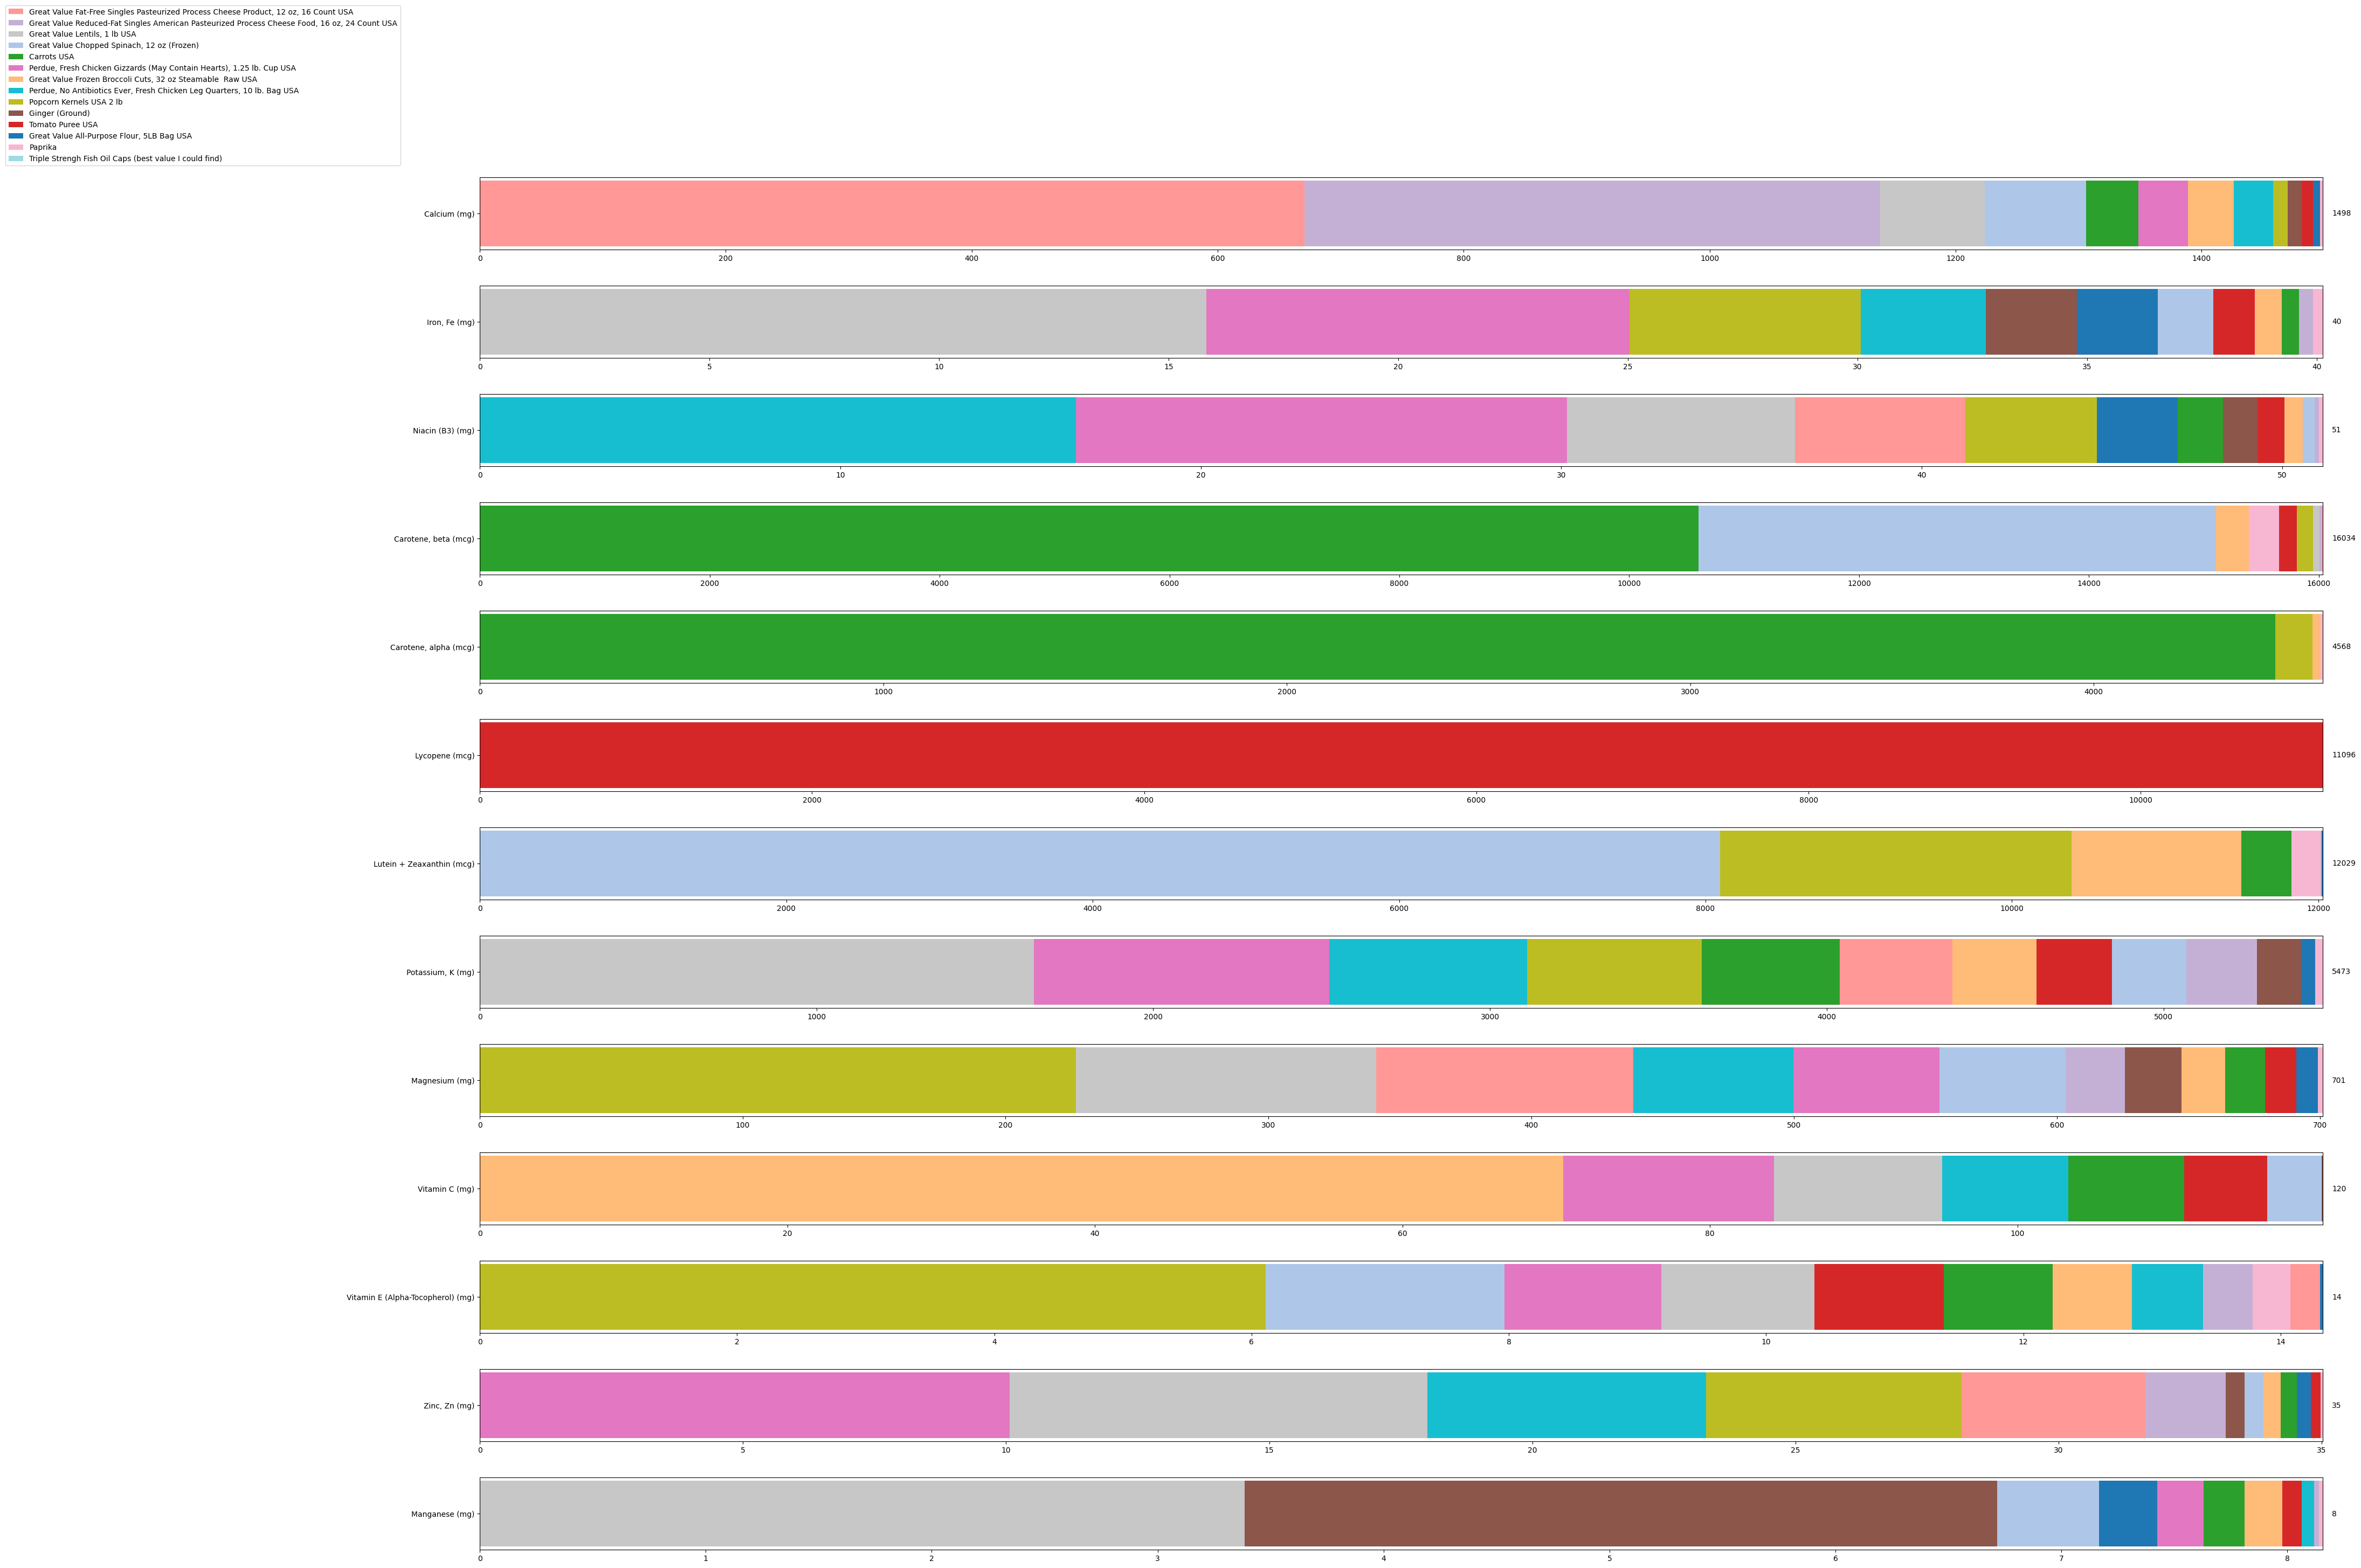

In [234]:
# Other plots



# Example usage:
#PlotContributions('Protein (g)', 'Calories', 'Fat (g)', 'Net Carbs (g)')

PlotContributions('Calories', 'Protein (g)', 'Net Carbs (g)','Fat (g)', 'Fiber (g)', 'Sugars (g)', 'Saturated Fats (g)')

PlotContributions('Calcium (mg)', 'Iron, Fe (mg)', 'Niacin (B3) (mg)', 'Carotene, beta (mcg)', 'Carotene, alpha (mcg)', 'Lycopene (mcg)', 'Lutein + Zeaxanthin (mcg)','Potassium, K (mg)', 'Magnesium (mg)', 'Vitamin C (mg)', 'Vitamin E (Alpha-Tocopherol) (mg)', 'Zinc, Zn (mg)', 'Manganese (mg)')

In [199]:
Weight_lbs = 194
BF_Percent = 0.17
LBM = Weight_lbs-(Weight_lbs*BF_Percent)

#For Maintenance
Caloric_Multiplier = 15.1 #Calculated based on pre-cut maintenance; use a value 16-18 typically
Extra_Caloric_Multiplier = 1 #Percentage, use for extra 'fudge' factor tbh?

total_calories = Weight_lbs*Caloric_Multiplier*Extra_Caloric_Multiplier
protein_minimum = 1.5*LBM # 1.1 - 1.4 g / lbm protein for athletes, 1.4 - 1.5 g / lbm protein when dieting, (I'm just using the top of the range 1.5 g / lbm cuz im awesome)
fat_minimum = 0.25*total_calories/9
fat_maximum = 0.35*total_calories/9 #not really necessary, but why not, carbs provide more energy anyway
net_carb_minimum = total_calories-(protein_minimum*4+fat_maximum*9)


#For PSMF

extra_PSMF_multiplier = 1 # extra adjustment factor (in %), normally leave 1
lbm_protein_multiplier_table_for_PSMF = {
    0.01: 2.0,
    0.02: 2.0,
    0.03: 2.0,
    0.04: 2.0,
    0.05: 2.0,
    0.06: 2.0,
    0.07: 2.0,
    0.08: 2.0,
    0.09: 2.0,
    0.1: 2.0,
    0.11: 1.94,
    0.12: 1.88,
    0.13: 1.81,
    0.14: 1.75,
    0.15: 1.71,
    0.16: 1.66,
    0.17: 1.61,
    0.18: 1.56,
    0.19: 1.51,
    0.2: 1.46,
    0.21: 1.41,
    0.22: 1.36,
    0.23: 1.31,
    0.24: 1.26,
    0.25: 1.21,
    0.26: 1.16,
    0.27: 1.11,
    0.28: 1.06,
    0.29: 1.01,
    0.3: 1.0,
    0.31: 1.0,
    0.32: 1.0,
    0.33: 1.0,
    0.34: 1.0,
    0.35: 1.0
}

protein_minimum = LBM * lbm_protein_multiplier_table_for_PSMF[BF_Percent] * extra_PSMF_multiplier
net_carb_maximum = 25 #some leeway for incidental carbs
fiber_lbound = 10 #some fiber for regularity
fat_maximum = 50 #some leeway for fats
protein_quality_minimum = 0.4
#maintenance cal main equation -> becomes protein instead 

In [200]:
# Defining Constraints
# TODO: PULL THESE FROM SOMEWHERE ELSE, MAYBE READ CSV THAT HAS BODYWEIGHT AND OTHER STATS AND COMPUTE THE MAINTENANCE AND OTHER NEEDS BASED ON 
# Macros
maintenance_calories = 2937  # set maintenance calories
protein_minimum = 242  # set protein minimum
net_carb_minimum = 236  # set net carb minimum
fiber_lbound = 30  # lower bound for fiber
fiber_ubound = 60  # upper bound for fiber
fat_minimum = 82
protein_quality_minimum = 0.4  # this is a fraction ie 0.4 = 40%
sugar_maximum = 75
sat_fat_maximum = 0.5  # this is a fraction